# Recognizing hand-written digits with neural networks

**Neural network Python libraries**
- *Keras*: High level library based on Tensorflow (or others) that is easy to use and flexible enough for most standard users. It has a great documentation and online support. 
- *Tensorflow*: Google's neural network library. Most widely used in ML research. Flexible and powerful but also (unnecessarily?) complicated.
- *Pytorch*: The newcomer developed by Facebook. Flexible like Tensorflow but with a nicer, more Pythonic API.

In this notebook we will tackle a classification task, recognizing hand-written digits of the famous MNIST dataset.

In [1]:
%matplotlib inline
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.


## MNIST - Preparing and exploring the data

Keras has a handy function to download the entire MNIST dataset which consists of 60,000 training images and 10000 test images.

In [37]:
(x_trn, y_trn), (x_test, y_test) = keras.datasets.mnist.load_data()

In [38]:
x_trn.shape, y_trn.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**STOP!** What are training, validation and test sets?

- Training set: Data used to optimize the machine learning algorithm
- Validation set: Data used to independently verify the skill of the algorithm
- Test set: Another independent set used for *final* verification.

Let's make a validation set.

In [ ]:
# Set a random seed to make train/valid split reproducible
np.random.seed(42)

In [39]:
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.2)

In [40]:
x_trn.shape, x_val.shape

((48000, 28, 28), (12000, 28, 28))

In [45]:
def plots(xs, ys):
    nfigs = xs.shape[0]; ncols = min(3, nfigs); nrows = int(np.floor(nfigs / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    for i, ax in enumerate(axs.flat):
        ax.imshow(xs[i], cmap='gray')
        ax.set_title(str(ys[i]))
        ax.set_xticks([]); ax.set_yticks([])

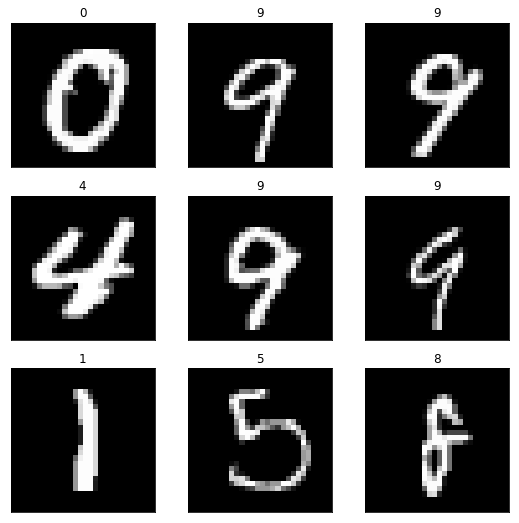

In [46]:
plots(x_trn[:9], y_trn[:9])

For gradient descent to work efficiently it is important that all the input variables or features are roughly on the same order of magnitude. Typically, we try to get them around 1.

In [47]:
def normalize(x): return x / 255

In [48]:
x_trn = normalize(x_trn)
x_val = normalize(x_val)

In [49]:
x_trn[0, 12:15, 12:15]

array([[ 0.05098039,  0.        ,  0.        ],
       [ 0.36078431,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

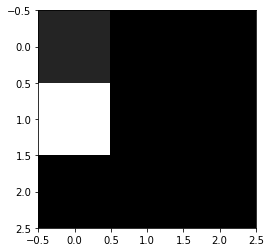

In [50]:
plt.imshow(x_trn[0, 12:15, 12:15], cmap='gray');

Now we will do something pretty dumb. We will flatten out the images and throw away all spatial information.

In [51]:
def flatten(x): return x.reshape(x.shape[0], -1)

In [52]:
x_trn = flatten(x_trn)
x_val = flatten(x_val)

In [53]:
x_trn.shape

(48000, 784)

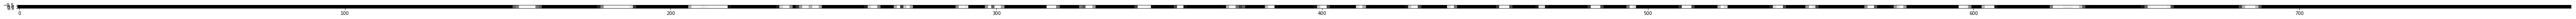

In [54]:
fig = plt.figure(figsize=(100, 1))
plt.imshow(x_trn[0, None, :], cmap='gray');

We are dealing with a classification problem. That means that the correct answer to always one of 10 classes. To pass the numbers to the neural net we one-hot encode the labels.

In [55]:
yoh_trn = to_categorical(y_trn)
yoh_val = to_categorical(y_val)

In [56]:
y_trn[:3], yoh_trn[:3]

(array([0, 9, 9], dtype=uint8),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]]))

## Training a simple linear network

To start, let's train a simple linear network.

In [62]:
linear_model = Sequential([
    Dense(10, input_shape=(784,), activation='softmax'),
])

After the matrix multiplication we are using a Softmax layer.

In [63]:
def softmax(x):
    np.exp(x) / np.sum(np.exp(x))

In [64]:
x = [2, 6, 3, 5]

In [65]:
np.exp(x)

array([   7.3890561 ,  403.42879349,   20.08553692,  148.4131591 ])

In [66]:
out = np.exp(x) / np.sum(np.exp(x))
out, out.sum()

(array([ 0.01275478,  0.69638749,  0.03467109,  0.25618664]), 1.0)

Next we need to judge how good our predictions is. For classification we use the categorical crossentropy:

$L = - \sum_c y_t^c \log(y_p^c)$

$c$ is the class, so one of our ten numbers.

In [67]:
linear_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [68]:
linear_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [71]:
linear_model.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 2s 32us/step - loss: 1.2356 - acc: 0.7020 - val_loss: 0.7268 - val_acc: 0.8385
Epoch 2/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.6034 - acc: 0.8606 - val_loss: 0.5216 - val_acc: 0.8721
Epoch 3/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.4760 - acc: 0.8823 - val_loss: 0.4449 - val_acc: 0.8850
Epoch 4/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.4179 - acc: 0.8935 - val_loss: 0.4039 - val_acc: 0.8923
Epoch 5/10
48000/48000 [==============================] - 1s 24us/step - loss: 0.3836 - acc: 0.9001 - val_loss: 0.3775 - val_acc: 0.8991
Epoch 6/10
48000/48000 [==============================] - 1s 24us/step - loss: 0.3602 - acc: 0.9049 - val_loss: 0.3593 - val_acc: 0.9032
Epoch 7/10
48000/48000 [==============================] - 1s 23us/step - loss: 0.3438 - acc: 0.9080 - val_loss: 0.3467 - val_acc

In [76]:
preds = linear_model.predict(x_val, 4096)

In [77]:
preds[:3]

array([[  1.77368245e-04,   4.82977412e-05,   1.11570593e-03,
          2.78864500e-05,   1.83108598e-01,   9.39771598e-06,
          7.83851147e-01,   7.28723853e-06,   4.62866388e-03,
          2.70256419e-02],
       [  9.58559394e-01,   2.05343508e-06,   4.20646771e-04,
          1.91771006e-03,   1.12979387e-06,   3.16585489e-02,
          9.01558888e-05,   7.55626243e-05,   7.22245546e-03,
          5.24335301e-05],
       [  5.59759997e-07,   3.44581419e-10,   4.33685746e-05,
          5.52379515e-06,   9.98886645e-01,   3.72307909e-06,
          1.09675939e-05,   2.44828389e-08,   2.98440173e-05,
          1.01934676e-03]], dtype=float32)

In [80]:
num_preds = np.argmax(preds, axis=1); num_preds[:3]

array([6, 0, 4])

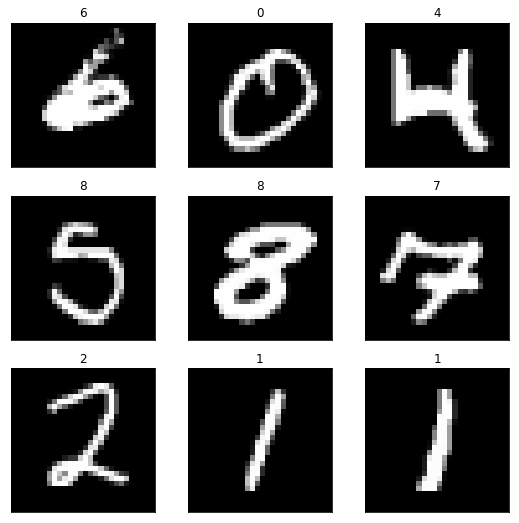

In [81]:
plots(x_val[:9].reshape(-1, 28, 28), num_preds[:9])

## A neural network

A neural network consists of several layers, connected by matrix multiplications. Layers between the input and output layer are called hidden layers. The activations in these layers are passed through a non-linear activation function.

Neural networks can approximate any non-linear function: http://neuralnetworksanddeeplearning.com/chap4.html

In [82]:
neural_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dense(10, activation='softmax'),
])

In [83]:
neural_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [84]:
neural_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [85]:
neural_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 120us/step - loss: 0.4628 - acc: 0.8746 - val_loss: 0.2439 - val_acc: 0.9327
Epoch 2/10
48000/48000 [==============================] - 5s 113us/step - loss: 0.1951 - acc: 0.9454 - val_loss: 0.1776 - val_acc: 0.9498
Epoch 3/10
48000/48000 [==============================] - 5s 113us/step - loss: 0.1416 - acc: 0.9603 - val_loss: 0.1432 - val_acc: 0.9586
Epoch 4/10
48000/48000 [==============================] - 6s 115us/step - loss: 0.1102 - acc: 0.9689 - val_loss: 0.1242 - val_acc: 0.9628
Epoch 5/10
48000/48000 [==============================] - 5s 114us/step - loss: 0.0889 - acc: 0.9751 - val_loss: 0.1077 - val_acc: 0.9674
Epoch 6/10
48000/48000 [==============================] - 5s 112us/step - loss: 0.0724 - acc: 0.9798 - val_loss: 0.0998 - val_acc: 0.9708
Epoch 7/10
48000/48000 [==============================] - 6s 119us/step - loss: 0.0603 - acc: 0.9836 - val_loss: 0.0938 - 

### Deep neural networks

In [87]:
deep_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

In [88]:
deep_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [89]:
deep_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total para

In [90]:
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 213us/step - loss: 0.5697 - acc: 0.8233 - val_loss: 0.1943 - val_acc: 0.9386
Epoch 2/10
48000/48000 [==============================] - 9s 189us/step - loss: 0.1945 - acc: 0.9418 - val_loss: 0.1308 - val_acc: 0.9602
Epoch 3/10
48000/48000 [==============================] - 9s 197us/step - loss: 0.1361 - acc: 0.9594 - val_loss: 0.1076 - val_acc: 0.9659
Epoch 4/10
48000/48000 [==============================] - 9s 197us/step - loss: 0.1087 - acc: 0.9668 - val_loss: 0.0891 - val_acc: 0.9723
Epoch 5/10
48000/48000 [==============================] - 10s 201us/step - loss: 0.0865 - acc: 0.9743 - val_loss: 0.0886 - val_acc: 0.9722
Epoch 6/10
48000/48000 [==============================] - 10s 200us/step - loss: 0.0715 - acc: 0.9772 - val_loss: 0.0824 - val_acc: 0.9749
Epoch 7/10
48000/48000 [==============================] - 9s 198us/step - loss: 0.0606 - acc: 0.9804 - val_loss: 0.0795

In [91]:
deep_net.optimizer.lr=1e-4
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 9s 189us/step - loss: 0.0399 - acc: 0.9874 - val_loss: 0.0839 - val_acc: 0.9772
Epoch 2/10
48000/48000 [==============================] - 9s 188us/step - loss: 0.0393 - acc: 0.9873 - val_loss: 0.0753 - val_acc: 0.9790
Epoch 3/10
48000/48000 [==============================] - 9s 192us/step - loss: 0.0335 - acc: 0.9888 - val_loss: 0.0798 - val_acc: 0.9800
Epoch 4/10
48000/48000 [==============================] - 9s 196us/step - loss: 0.0313 - acc: 0.9897 - val_loss: 0.0799 - val_acc: 0.9793
Epoch 5/10
48000/48000 [==============================] - 11s 219us/step - loss: 0.0275 - acc: 0.9905 - val_loss: 0.0736 - val_acc: 0.9814
Epoch 6/10
48000/48000 [==============================] - 15s 316us/step - loss: 0.0276 - acc: 0.9906 - val_loss: 0.0813 - val_acc: 0.9789
Epoch 7/10
48000/48000 [==============================] - 10s 219us/step - loss: 0.0248 - acc: 0.9917 - val_loss: 0.0786

## Convolutions

To take advantage of the spatial information in images we can use convolutions rather than fully connected layers.

http://setosa.io/ev/image-kernels/

In [110]:
conv_net = Sequential([
    Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(10, kernel_size=3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Activation('softmax')
])

In [111]:
conv_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 2, 10)          11530     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 10)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 104,714
Trainable params: 104,714
Non-trainable params: 0
_________________________________________________________________


In [112]:
conv_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [113]:
conv_net.fit(x_trn.reshape(-1, 28, 28, 1), yoh_trn, batch_size=512, epochs=10, 
             validation_data=(x_val.reshape(-1, 28, 28, 1), yoh_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 41s 862us/step - loss: 0.8061 - acc: 0.7725 - val_loss: 0.3387 - val_acc: 0.8976
Epoch 2/10
48000/48000 [==============================] - 39s 815us/step - loss: 0.2626 - acc: 0.9229 - val_loss: 0.2102 - val_acc: 0.9384
Epoch 3/10
48000/48000 [==============================] - 40s 828us/step - loss: 0.1729 - acc: 0.9495 - val_loss: 0.1646 - val_acc: 0.9504
Epoch 4/10
48000/48000 [==============================] - 40s 828us/step - loss: 0.1275 - acc: 0.9624 - val_loss: 0.1291 - val_acc: 0.9617
Epoch 5/10
48000/48000 [==============================] - 41s 845us/step - loss: 0.0998 - acc: 0.9694 - val_loss: 0.1036 - val_acc: 0.9679
Epoch 6/10
48000/48000 [==============================] - 40s 829us/step - loss: 0.0829 - acc: 0.9746 - val_loss: 0.0948 - val_acc: 0.9727
Epoch 7/10
48000/48000 [==============================] - 40s 824us/step - loss: 0.0724 - acc: 0.9780 - val_loss: 0.

## End